# Min-dalle classes

In [ ]:
import os
if not os.path.isfile('/content/once.txt'):
  !pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 34.8 MB/s 


In [ ]:
%%writefile /content/once.txt
uwa

Writing /content/once.txt


In [ ]:
IMAGE_TOKEN_COUNT = 256


from PIL import Image
import numpy as np
from threading import Thread

import torch
from torch import LongTensor, FloatTensor,nn, BoolTensor
from math import sqrt

import torch.backends.cudnn, torch.backends.cuda
import json
import requests
from typing import Iterator,List, Tuple, Dict
from math import inf



torch.set_grad_enabled(False)
torch.set_num_threads(os.cpu_count())
torch.backends.cudnn.enabled = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True

MIN_DALLE_REPO = 'https://huggingface.co/kuprel/min-dalle/resolve/main/'


BLANK_TOKEN = 6965

Ber encoder

In [ ]:
class GLU(nn.Module):
    def __init__(self, count_in_out, count_middle):
        super().__init__()
        self.gelu = nn.GELU()
        self.ln0 = nn.LayerNorm(count_in_out)
        self.ln1 = nn.LayerNorm(count_middle)
        self.fc0 = nn.Linear(count_in_out, count_middle, bias=False)
        self.fc1 = nn.Linear(count_in_out, count_middle, bias=False)
        self.fc2 = nn.Linear(count_middle, count_in_out, bias=False)
    
    def forward(self, z: FloatTensor) -> FloatTensor:
        z = self.ln0.forward(z)
        w = self.fc0.forward(z)
        w = self.gelu.forward(w)
        v = self.fc1.forward(z)
        z = self.ln1.forward(w * v)
        z = self.fc2.forward(z)
        return z


class AttentionBase(nn.Module):
    def __init__(self, head_count: int, embed_count: int):
        super().__init__()
        self.head_count = head_count
        self.embed_count = embed_count

        self.k_proj = nn.Linear(embed_count, embed_count, bias=False)
        self.v_proj = nn.Linear(embed_count, embed_count, bias=False)
        self.q_proj = nn.Linear(embed_count, embed_count, bias=False)
        self.out_proj = nn.Linear(embed_count, embed_count, bias=False)
        self.one = torch.ones((1, 1))
        if torch.cuda.is_available(): self.one = self.one.cuda()
    
    def forward(
        self,
        keys: FloatTensor,
        values: FloatTensor,
        queries: FloatTensor,
        attention_mask: BoolTensor
    ) -> FloatTensor:
        keys = keys.reshape(keys.shape[:2] + (self.head_count, -1))
        values = values.reshape(values.shape[:2] + (self.head_count, -1))
        queries = queries.reshape(queries.shape[:2] + (self.head_count, -1))
        queries /= queries.shape[-1] ** 0.5

        attention_bias = torch.where(
            attention_mask,
            self.one * 0,
            self.one * (-torch.inf),
        )
        attention_weights: FloatTensor = torch.einsum(
            'bqhc,bkhc->bhqk',
            queries, 
            keys
        )
        attention_weights += attention_bias[:, None, None, :]
        attention_weights = torch.softmax(attention_weights, -1)
        attention_output: FloatTensor = torch.einsum(
            "bhqk,bkhc->bqhc",
            attention_weights, 
            values
        )
        shape = attention_output.shape[:2] + (self.embed_count,)
        attention_output = attention_output.reshape(shape)
        attention_output = self.out_proj.forward(attention_output)
        return attention_output


class EncoderSelfAttention(AttentionBase):
    def forward(
        self,
        encoder_state: FloatTensor,
        attention_mask: BoolTensor
    ) -> FloatTensor:
        keys = self.k_proj.forward(encoder_state)
        values = self.v_proj.forward(encoder_state)
        queries = self.q_proj.forward(encoder_state)
        return super().forward(keys, values, queries, attention_mask)


class EncoderLayer(nn.Module):
    def __init__(self, embed_count: int, head_count: int, glu_embed_count: int):
        super().__init__()
        self.pre_self_attn_layer_norm = nn.LayerNorm(embed_count)
        self.self_attn = EncoderSelfAttention(head_count, embed_count)
        self.self_attn_layer_norm = nn.LayerNorm(embed_count)
        self.glu = GLU(embed_count, glu_embed_count)
    
    def forward(
        self,
        encoder_state: FloatTensor,
        attention_mask: BoolTensor
    ) -> FloatTensor:
        residual = encoder_state
        encoder_state = self.pre_self_attn_layer_norm.forward(encoder_state)
        encoder_state = self.self_attn.forward(encoder_state, attention_mask)
        encoder_state = self.self_attn_layer_norm.forward(encoder_state)
        encoder_state = residual + encoder_state
        residual = encoder_state
        encoder_state = self.glu.forward(encoder_state)
        encoder_state = residual + encoder_state
        return encoder_state


class DalleBartEncoder(nn.Module):
    def __init__(
        self,
        layer_count: int,
        embed_count: int,
        attention_head_count: int,
        text_vocab_count: int,
        text_token_count: int,
        glu_embed_count: int
    ):
        super().__init__()
        self.text_vocab_count = text_vocab_count
        self.embed_tokens = nn.Embedding(text_vocab_count, embed_count)
        self.embed_positions = nn.Embedding(text_token_count, embed_count)
        self.layers: List[EncoderLayer] = nn.ModuleList([
            EncoderLayer(
                embed_count = embed_count,
                head_count = attention_head_count,
                glu_embed_count = glu_embed_count
            ) 
            for _ in range(layer_count)
        ])
        self.layernorm_embedding = nn.LayerNorm(embed_count)
        self.final_ln = nn.LayerNorm(embed_count)
        self.token_indices = torch.arange(text_token_count).to(torch.long)
        if torch.cuda.is_available(): 
            self.token_indices = self.token_indices.cuda()

    def forward(self, text_tokens: LongTensor) -> FloatTensor:
        attention_mask = text_tokens.not_equal(1)
        pose_tokens = self.token_indices[None][[0] * text_tokens.shape[0]]
        text_tokens.clamp_(0, self.text_vocab_count - 1)
        encoder_state = (
            self.embed_tokens.forward(text_tokens) +
            self.embed_positions.forward(pose_tokens)
        )
        encoder_state = self.layernorm_embedding.forward(encoder_state)
        for layer in self.layers:
            encoder_state = layer.forward(encoder_state, attention_mask)
        encoder_state = self.final_ln.forward(encoder_state)
        return encoder_state

Bert Decoder

In [ ]:
class DecoderCrossAttention(AttentionBase):
    def forward(
        self,
        decoder_state: FloatTensor,
        encoder_state: FloatTensor,
        attention_mask: BoolTensor
    ) -> FloatTensor:
        keys = self.k_proj.forward(encoder_state)
        values = self.v_proj.forward(encoder_state)
        queries = self.q_proj.forward(decoder_state)
        return super().forward(keys, values, queries, attention_mask)


class DecoderSelfAttention(AttentionBase):
    def __init__(self, head_count: int, embed_count: int):
        super().__init__(head_count, embed_count)
        token_indices = torch.arange(IMAGE_TOKEN_COUNT)
        if torch.cuda.is_available(): token_indices = token_indices.cuda()
        self.token_indices = token_indices

    def forward(
        self, 
        decoder_state: FloatTensor,
        attention_state: FloatTensor,
        token_index: LongTensor
    ) -> Tuple[FloatTensor, FloatTensor]:
        keys = self.k_proj.forward(decoder_state)
        values = self.v_proj.forward(decoder_state)
        queries = self.q_proj.forward(decoder_state)
        attn_mask = self.token_indices < token_index + 1
        attn_mask = attn_mask[None][[0] * decoder_state.shape[0]]
        attn_state_new = torch.cat([keys, values]).to(attention_state.dtype)
        attention_state[:, token_index] = attn_state_new
        batch_count = decoder_state.shape[0]
        keys = attention_state[:batch_count]
        values = attention_state[batch_count:]
        decoder_state = super().forward(keys, values, queries, attn_mask)
        return decoder_state, attention_state


class DecoderLayer(nn.Module):
    def __init__(
        self, 
        head_count: int, 
        embed_count: int,
        glu_embed_count: int
    ):
        super().__init__()
        self.pre_self_attn_layer_norm = nn.LayerNorm(embed_count)
        self.self_attn = DecoderSelfAttention(head_count, embed_count)
        self.self_attn_layer_norm = nn.LayerNorm(embed_count)
        self.pre_encoder_attn_layer_norm = nn.LayerNorm(embed_count)
        self.encoder_attn = DecoderCrossAttention(head_count, embed_count)
        self.encoder_attn_layer_norm = nn.LayerNorm(embed_count)
        self.glu = GLU(embed_count, glu_embed_count)


    def forward(
        self,
        decoder_state: FloatTensor,
        encoder_state: FloatTensor,
        attention_state: FloatTensor,
        attention_mask: BoolTensor,
        token_index: LongTensor
    ) -> Tuple[FloatTensor, FloatTensor]:
        # Self Attention
        residual = decoder_state
        decoder_state = self.pre_self_attn_layer_norm.forward(decoder_state)
        decoder_state, attention_state = self.self_attn.forward(
            decoder_state,
            attention_state,
            token_index
        )
        decoder_state = self.self_attn_layer_norm.forward(decoder_state)
        decoder_state = residual + decoder_state

        # Cross Attention
        residual = decoder_state
        decoder_state = self.pre_encoder_attn_layer_norm.forward(decoder_state)
        decoder_state = self.encoder_attn.forward(
            decoder_state,
            encoder_state,
            attention_mask
        )
        decoder_state = self.encoder_attn_layer_norm.forward(decoder_state)
        decoder_state = residual + decoder_state

        # Feed forward
        residual = decoder_state
        decoder_state = self.glu.forward(decoder_state)
        decoder_state = residual + decoder_state

        return decoder_state, attention_state


class DalleBartDecoder(nn.Module):
    def __init__(
        self,
        image_vocab_count: int,
        embed_count: int,
        attention_head_count: int,
        glu_embed_count: int,
        layer_count: int,
        start_token: int
    ):
        super().__init__()
        self.layer_count = layer_count
        self.embed_count = embed_count
        self.image_vocab_count = image_vocab_count
        self.embed_tokens = nn.Embedding(image_vocab_count + 1, embed_count)
        self.embed_positions = nn.Embedding(IMAGE_TOKEN_COUNT, embed_count)
        self.layers: List[DecoderLayer] = nn.ModuleList([
            DecoderLayer(
                attention_head_count,
                embed_count,
                glu_embed_count
            ) 
            for _ in range(layer_count)
        ])
        self.layernorm_embedding = nn.LayerNorm(embed_count)
        self.final_ln = nn.LayerNorm(embed_count)
        self.lm_head = nn.Linear(embed_count, image_vocab_count + 1, bias=False)
        self.zero_prob = torch.zeros([1])
        self.token_indices = torch.arange(IMAGE_TOKEN_COUNT)
        self.start_token = torch.tensor([start_token]).to(torch.long)
        if torch.cuda.is_available():
            self.zero_prob = self.zero_prob.cuda()
            self.token_indices = self.token_indices.cuda()
            self.start_token = self.start_token.cuda()


    def decode_step(
        self,
        temperature: float,
        top_k: int,
        supercondition_factor: int,
        attention_mask: BoolTensor,
        encoder_state: FloatTensor,
        attention_state: FloatTensor,
        prev_tokens: LongTensor,
        token_index: LongTensor
    ) -> Tuple[FloatTensor, FloatTensor]:
        image_count = encoder_state.shape[0] // 2
        token_index_batched = token_index[[0] * image_count * 2]
        prev_tokens = prev_tokens[list(range(image_count)) * 2]
        prev_tokens.clamp_(0, self.image_vocab_count)
        decoder_state = self.embed_tokens.forward(prev_tokens)
        decoder_state += self.embed_positions.forward(token_index_batched)
        decoder_state = self.layernorm_embedding.forward(decoder_state)
        decoder_state = decoder_state[:, None]
        for i in range(self.layer_count):
            decoder_state, attention_state[i] = self.layers[i].forward(
                decoder_state,
                encoder_state,
                attention_state[i],
                attention_mask,
                token_index
            )
        decoder_state = self.final_ln(decoder_state)
        logits = self.lm_head(decoder_state)
        a = supercondition_factor
        logits: FloatTensor = (
            logits[:image_count, -1] * (1 - a) + 
            logits[image_count:, -1] * a
        )

        top_logits, _ = logits.topk(top_k, dim=-1)
        is_kept = logits >= top_logits[:, [-1]]
        logits -= top_logits[:, [0]]
        logits /= max(temperature, 1e-6)
        probs = torch.where(is_kept, torch.exp(logits), self.zero_prob)
        probs[:, 2 ** 14:] = 0              # vqgan vocab_count is only 2 ** 14
        return probs, attention_state


    def decode_row(
        self,
        row_index: int,
        temperature: float,
        top_k: int,
        supercondition_factor: int,
        encoder_state: FloatTensor,
        attention_mask: BoolTensor,
        attention_state: FloatTensor,
        image_tokens_sequence: LongTensor
    ) -> Tuple[FloatTensor, LongTensor]:
        for col_index in range(16):
            i = 16 * row_index + col_index
            probs, attention_state = self.decode_step(
                temperature = temperature,
                top_k = top_k,
                supercondition_factor = supercondition_factor,
                attention_mask = attention_mask,
                encoder_state = encoder_state,
                attention_state = attention_state,
                prev_tokens = image_tokens_sequence[:, i],
                token_index = self.token_indices[[i]]
            )
            image_tokens_sequence[:, i + 1] = torch.multinomial(probs, 1)[:, 0]

        return attention_state, image_tokens_sequence

    
    def decode_initial(
        self,
        seed: int,
        image_count: int,
        text_tokens: LongTensor,
        encoder_state: FloatTensor
    ) -> Tuple[FloatTensor, FloatTensor, FloatTensor, LongTensor]:
        expanded_indices = [0] * image_count + [1] * image_count
        text_tokens = text_tokens[expanded_indices]
        encoder_state = encoder_state[expanded_indices]
        attention_mask = text_tokens.not_equal(1)

        attention_state_shape = (
            self.layer_count,
            image_count * 4,
            IMAGE_TOKEN_COUNT,
            self.embed_count
        )
        attention_state = torch.zeros(attention_state_shape)
        image_tokens_sequence = torch.full(
            (image_count, IMAGE_TOKEN_COUNT + 1), 
            BLANK_TOKEN,
            dtype=torch.long
        )
        if torch.cuda.is_available(): 
            attention_state = attention_state.cuda()
            image_tokens_sequence = image_tokens_sequence.cuda()
        
        image_tokens_sequence[:, 0] = self.start_token[0]

        if seed > 0: torch.manual_seed(seed)

        return encoder_state, attention_mask, attention_state, image_tokens_sequence

Tokenizer

In [ ]:
class TextTokenizer:
    def __init__(self, vocab: dict, merges: List[str]):
        self.token_from_subword = vocab
        pairs = [tuple(pair.split()) for pair in merges]
        self.rank_from_pair = dict(zip(pairs, range(len(pairs))))

    def tokenize(self, text: str, is_verbose: bool = False) -> List[int]:
        sep_token = self.token_from_subword['</s>']
        cls_token = self.token_from_subword['<s>']
        unk_token = self.token_from_subword['<unk>']
        text = text.lower().encode("ascii", errors="ignore").decode()
        tokens = [
            self.token_from_subword.get(subword, unk_token)
            for word in text.split(" ") if len(word) > 0
            for subword in self.get_byte_pair_encoding(word, is_verbose)
        ]
        return [cls_token] + tokens + [sep_token]

    def get_byte_pair_encoding(self, word: str, is_verbose: bool) -> List[str]:
        def get_pair_rank(pair: Tuple[str, str]) -> int:
            return self.rank_from_pair.get(pair, inf)

        subwords = [chr(ord(" ") + 256)] + list(word)
        while len(subwords) > 1:
            pairs = list(zip(subwords[:-1], subwords[1:]))
            pair_to_merge = min(pairs, key=get_pair_rank)
            if pair_to_merge not in self.rank_from_pair: break
            i = pairs.index(pair_to_merge)
            subwords = (
                (subwords[:i] if i > 0 else []) + 
                [subwords[i] + subwords[i + 1]] + 
                (subwords[i + 2:] if i + 2 < len(subwords) else [])
            )

        if is_verbose: print(subwords)
        return subwords


MinDalle class

In [ ]:
from accelerate import init_empty_weights

def get_keys_to_submodule(model: nn.Module) -> Dict[str, nn.Module]:
    keys_to_submodule = {}
    # iterate all submodules
    for submodule_name, submodule in model.named_modules():
        # iterate all paramters in each submobule
        for param_name, param in submodule.named_parameters():
            # param_name is organized as <name>.<subname>.<subsubname> ...
            # the more we go deep in the model, the less "subname"s we have
            splitted_param_name = param_name.split('.')
            # if we have only one subname, then it means that we reach a "leaf" submodule, 
            # we cannot go inside it anymore. This is the actual parameter
            is_leaf_param = len(splitted_param_name) == 1
            if is_leaf_param:
                # we recreate the correct key
                key = f"{submodule_name}.{param_name}"
                # we associate this key with this submodule
                keys_to_submodule[key] = submodule
                
    return keys_to_submodule

def load_state_dict_with_low_memory(model: nn.Module, state_dict):
    # free up memory by placing the model in the `meta` device
    keys_to_submodule = get_keys_to_submodule(model)
    mste=model.state_dict()
    for key, submodule in keys_to_submodule.items():
        # get the valye from the state_dict
        if key in state_dict:
          val = state_dict[key]
        else:
          val = torch.ones(mste[key].shape, dtype= torch.float16)
        # we need to substitute the parameter inside submodule, 
        # remember key is composed of <name>.<subname>.<subsubname>
        # the actual submodule's parameter is stored inside the 
        # last subname. If key is `in_proj.weight`, the correct field if `weight`
        param_name = key.split('.')[-1]
        #param_dtype = getattr(submodule, param_name).dtype
        #val = val.to(param_dtype)
        # create a new parameter
        new_val = torch.nn.Parameter(val)
        setattr(submodule, param_name, new_val)


def init2(mdl,path):
  load_state_dict_with_low_memory(mdl, torch.load(path,map_location='cpu'))
  #mdl.load_state_dict(params, strict=False)
  mdl.eval()
  


class MinDalle:
    def __init__(
        self,
        models_root: str = 'pretrained',
        dtype: torch.dtype = torch.float32,
        is_mega: bool = True, 
        is_reusable: bool = True,
        is_verbose = True
    ):
        self.is_mega = is_mega
        self.is_reusable = is_reusable
        self.dtype = dtype
        self.is_verbose = is_verbose
        self.text_token_count = 64
        self.layer_count = 24 if is_mega else 12
        self.attention_head_count = 32 if is_mega else 16
        self.embed_count = 2048 if is_mega else 1024
        self.glu_embed_count = 4096 if is_mega else 2730
        self.text_vocab_count = 50272 if is_mega else 50264
        self.image_vocab_count = 16415 if is_mega else 16384

        model_name = 'dalle_bart_{}'.format('mega' if is_mega else 'mini')
        dalle_path = os.path.join(models_root, model_name)
        vqgan_path = os.path.join(models_root, 'vqgan')
        if not os.path.exists(dalle_path): os.makedirs(dalle_path)
        if not os.path.exists(vqgan_path): os.makedirs(vqgan_path)
        self.vocab_path = os.path.join(dalle_path, 'vocab.json')
        self.merges_path = os.path.join(dalle_path, 'merges.txt')
        self.encoder_params_path = os.path.join(dalle_path, 'encoder.pt')
        self.decoder_params_path = os.path.join(dalle_path, 'decoder.pt')
        self.detoker_params_path = os.path.join(vqgan_path, 'detoker.pt')

        self.init_tokenizer()
        


    def download_tokenizer(self):
        if self.is_verbose: print("downloading tokenizer params")
        suffix = '' if self.is_mega else '_mini'
        vocab = requests.get(MIN_DALLE_REPO + 'vocab{}.json'.format(suffix))
        merges = requests.get(MIN_DALLE_REPO + 'merges{}.txt'.format(suffix))
        with open(self.vocab_path, 'wb') as f: f.write(vocab.content)
        with open(self.merges_path, 'wb') as f: f.write(merges.content)


    def download_encoder(self):
        if self.is_verbose: print("downloading encoder params")
        suffix = '' if self.is_mega else '_mini'
        urli=MIN_DALLE_REPO + 'encoder{}.pt'.format(suffix)
        !wget -O {self.encoder_params_path} {urli}
        #params = requests.get(MIN_DALLE_REPO + 'encoder{}.pt'.format(suffix))
        #with open(self.encoder_params_path, 'wb') as f: f.write(params.content)


    def download_decoder(self):
        if self.is_verbose: print("downloading decoder params")
        suffix = '' if self.is_mega else '_mini'
        urli=MIN_DALLE_REPO + 'decoder{}.pt'.format(suffix)
        !wget -O {self.decoder_params_path} {urli}
        #params = requests.get(MIN_DALLE_REPO + 'decoder{}.pt'.format(suffix))
        #with open(self.decoder_params_path, 'wb') as f: f.write(params.content)
    

    def download_detokenizer(self):
        if self.is_verbose: print("downloading detokenizer params")
        params = requests.get(MIN_DALLE_REPO + 'detoker.pt')
        with open(self.detoker_params_path, 'wb') as f: f.write(params.content)


    def init_tokenizer(self):
        is_downloaded = os.path.exists(self.vocab_path)
        is_downloaded &= os.path.exists(self.merges_path)
        if not is_downloaded: self.download_tokenizer()
        if self.is_verbose: print("intializing TextTokenizer")
        with open(self.vocab_path, 'r', encoding='utf8') as f:
            vocab = json.load(f)
        with open(self.merges_path, 'r', encoding='utf8') as f:
            merges = f.read().split("\n")[1:-1]
        self.tokenizer = TextTokenizer(vocab, merges)


    def init_encoder(self):
        is_downloaded = os.path.exists(self.encoder_params_path)
        if not is_downloaded: self.download_encoder()
        if self.is_verbose: print("initializing DalleBartEncoder")
        with init_empty_weights():
          self.encoder = DalleBartEncoder(
              attention_head_count = self.attention_head_count,
              embed_count = self.embed_count,
              glu_embed_count = self.glu_embed_count,
              text_token_count = self.text_token_count,
              text_vocab_count = self.text_vocab_count,
              layer_count = self.layer_count
          )
        init2(self.encoder,self.encoder_params_path)
        if torch.cuda.is_available(): self.encoder = self.encoder.cuda()
        
        


    def init_decoder(self):
        is_downloaded = os.path.exists(self.decoder_params_path)
        if not is_downloaded: self.download_decoder()
        if self.is_verbose: print("initializing DalleBartDecoder")
        with init_empty_weights():
          self.decoder = DalleBartDecoder(
              image_vocab_count = self.image_vocab_count,
              attention_head_count = self.attention_head_count,
              embed_count = self.embed_count,
              glu_embed_count = self.glu_embed_count,
              layer_count = self.layer_count,
              start_token = self.image_vocab_count
          )
        init2(self.decoder,self.decoder_params_path)
        if torch.cuda.is_available(): self.decoder = self.decoder.cuda()


    def init_detokenizer(self):
        is_downloaded = os.path.exists(self.detoker_params_path)
        if not is_downloaded: self.download_detokenizer()
        if self.is_verbose: print("initializing VQGanDetokenizer")
        self.detokenizer = VQGanDetokenizer().eval()
        params = torch.load(self.detoker_params_path)
        self.detokenizer.load_state_dict(params)
        del params
        if torch.cuda.is_available(): self.detokenizer = self.detokenizer.cuda()


    def images_from_tokens(
        self,
        image_tokens: LongTensor,
        is_verbose: bool = False
    ) -> FloatTensor:
        if not self.is_reusable: del self.decoder
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        if not self.is_reusable: self.init_detokenizer()
        if is_verbose: print("detokenizing image")
        images = self.detokenizer.forward(image_tokens).to(torch.uint8)
        if not self.is_reusable: del self.detokenizer
        return images


    def grid_from_images(self, images: FloatTensor) -> Image.Image:
        grid_size = int(sqrt(images.shape[0]))
        images = images.reshape([grid_size] * 2 + list(images.shape[1:]))
        image = images.flatten(1, 2).transpose(0, 1).flatten(1, 2)
        image = Image.fromarray(image.to('cpu').numpy())
        return image


    def generate_images_stream(
        self, 
        text: str, 
        seed: int,
        image_count: int,
        log2_mid_count: int,
        temperature: float = 1,
        top_k: int = 256,
        supercondition_factor: int = 16,
        is_verbose: bool = False
    ) -> Iterator[FloatTensor]:
        assert(log2_mid_count in range(5))
        if is_verbose: print("tokenizing text")
        tokens = self.tokenizer.tokenize(text, is_verbose=is_verbose)
        if len(tokens) > self.text_token_count: 
            tokens = tokens[:self.text_token_count]
        if is_verbose: print("{} text tokens".format(len(tokens)), tokens)
        text_tokens = numpy.ones((2, 64), dtype=numpy.int32)
        text_tokens[0, :2] = [tokens[0], tokens[-1]]
        text_tokens[1, :len(tokens)] = tokens

        text_tokens = torch.tensor(text_tokens).to(torch.long)
        if torch.cuda.is_available(): text_tokens = text_tokens.cuda()

        if not self.is_reusable: self.init_encoder()
        if is_verbose: print("encoding text tokens")
        with torch.cuda.amp.autocast(dtype=self.dtype):
            encoder_state = self.encoder.forward(text_tokens)
        if not self.is_reusable: del self.encoder
        if torch.cuda.is_available(): torch.cuda.empty_cache()

        if not self.is_reusable: self.init_decoder()

        with torch.cuda.amp.autocast(dtype=self.dtype):
            encoder_state, attention_mask, attention_state, image_tokens = ( 
                self.decoder.decode_initial(
                    seed=seed, 
                    image_count=image_count, 
                    text_tokens=text_tokens, 
                    encoder_state=encoder_state
                )
            )

        row_count = 16
        for row_index in range(row_count):
            if is_verbose: 
                print('sampling row {} of {}'.format(row_index + 1, row_count))
            with torch.cuda.amp.autocast(dtype=self.dtype):
                attention_state, image_tokens = self.decoder.decode_row(
                    row_index,
                    temperature=temperature,
                    top_k=top_k,
                    supercondition_factor=supercondition_factor,
                    encoder_state=encoder_state,
                    attention_mask=attention_mask,
                    attention_state=attention_state,
                    image_tokens_sequence=image_tokens
                )
            with torch.cuda.amp.autocast(dtype=torch.float32):
                if ((row_index + 1) * (2 ** log2_mid_count)) % row_count == 0:
                    tokens = image_tokens[:, 1:]
                    images = self.images_from_tokens(tokens, is_verbose)
                    yield images


    def generate_image_stream(
        self, 
        text: str, 
        seed: int,
        grid_size: int,
        log2_mid_count: int,
        temperature: float = 1,
        top_k: int = 256,
        supercondition_factor: int = 16,
        is_verbose: bool = False
    ) -> Iterator[Image.Image]:
        images_stream = self.generate_images_stream(
            text=text, 
            seed=seed,
            image_count=grid_size ** 2,
            log2_mid_count=log2_mid_count,
            temperature=temperature,
            top_k=top_k,
            supercondition_factor=supercondition_factor,
            is_verbose=is_verbose
        )
        for images in images_stream:
            yield self.grid_from_images(images)


    def generate_images(
        self, 
        text: str,
        seed: int = -1,
        image_count: int = 1,
        temperature: float = 1,
        top_k: int = 1024,
        supercondition_factor: int = 16,
        is_verbose: bool = False
    ) -> FloatTensor:
        log2_mid_count = 0
        images_stream = self.generate_images_stream(
            text=text,
            seed=seed,
            image_count=image_count,
            temperature=temperature,
            log2_mid_count=log2_mid_count,
            top_k=top_k,
            supercondition_factor=supercondition_factor,
            is_verbose=is_verbose
        )
        return next(images_stream)


    def generate_image(
        self, 
        text: str,
        seed: int = -1,
        grid_size: int = 1,
        temperature: float = 1,
        top_k: int = 1024,
        supercondition_factor: int = 16,
        is_verbose: bool = False
    ) -> Image.Image:
        log2_mid_count = 0
        image_stream = self.generate_image_stream(
            text=text,
            seed=seed,
            grid_size=grid_size,
            log2_mid_count=log2_mid_count,
            temperature=temperature,
            top_k=top_k,
            supercondition_factor=supercondition_factor,
            is_verbose=is_verbose
        )
        return next(image_stream)

new def funcs

In [ ]:
row_count = IMAGE_TOKEN_COUNT//16
def rumpla(n,dmp='ozv.bin'):
  global attention_state
  global image_tokens
  for row_index in range(n,row_count):
      print(str(row_index),end= '-')
      with torch.cuda.amp.autocast(dtype=torch.float16):
        attention_state, image_tokens = mindd.decoder.decode_row(
                        row_index,
                        temperature=temperature,
                        top_k=top_k,
                        supercondition_factor=supercondition_factor,
                        encoder_state=encoder_state,
                        attention_mask=attention_mask,
                        attention_state=attention_state,
                        image_tokens_sequence=image_tokens
                    )
      
      if ((row_index + 1) * (2 ** log2_mid_count)) % row_count == 0:
          tokens = image_tokens[:, 1:]
          
  hux=tokens.to('cpu').numpy().astype(np.uint16)
  with open(dmp,mode='ba+') as f:
    hux.tofile(f)


def intpencK():
  interpo(dumped_seqs[-1],dumped_seqs[-2])
  !rm /content/intp.webm
  !/content/ffmpeg-5.0.1-amd64-static/ffmpeg -framerate 18 -i /content/donn/%02d.png -sn -map_metadata -1 -map_chapters -1 -crf 10 -c:v libaom-av1 -aom-params enable-keyframe-filtering=0:enable-tpl-model=1 -lag-in-frames 48 -cpu-used 5 -row-mt 1 -tiles 1x1 -threads 2 -strict experimental -movflags +faststart -flags +cgop -pix_fmt yuv420p10le -c:a libopus -b:a 96k -ac 2 -f webm /content/intp.webm


!mkdir donn

# PlayGround

In [ ]:
mindd = MinDalle(is_mega=True, is_reusable=True)
mindd.init_decoder()
mindd.init_encoder()
newstart=True
mizu=0
!nvidia-smi

In [ ]:
text = "beautiful detailed rear legs maid knight of sea with bikini armor, highly detailed, 4K, UHD, High quality, Trending on Artstation HQ" 
seed = 77788
image_count= 1
log2_mid_count= 0
temperature= 1
top_k= 256
supercondition_factor= 16
is_verbose= False

tokens = mindd.tokenizer.tokenize(text, is_verbose=is_verbose)
if len(tokens) > mindd.text_token_count: 
    tokens = tokens[:mindd.text_token_count]

print("{} text tokens".format(len(tokens)), tokens)
text_tokens = np.ones((2, 64), dtype=np.int32)
text_tokens[0, :2] = [tokens[0], tokens[-1]]
text_tokens[1, :len(tokens)] = tokens

text_tokens = torch.tensor(text_tokens).to(torch.long).cuda()


with torch.cuda.amp.autocast(dtype=torch.float16):
  encoder_state_new = mindd.encoder.forward(text_tokens)



29 text tokens [0, 1687, 8461, 4666, 10127, 12740, 5397, 111, 2074, 208, 8694, 7215, 11, 13169, 8461, 11, 252, 38, 11, 20531, 11, 524, 1905, 11, 10119, 133, 4640, 8649, 2]


In [ ]:
encoder_state=encoder_state_new

In [ ]:
with torch.cuda.amp.autocast(dtype=torch.float16):
  encoder_state, attention_mask, attention_state, image_tokens_new = ( 
      mindd.decoder.decode_initial(
          seed=seed, 
          image_count=image_count, 
          text_tokens=text_tokens, 
          encoder_state=encoder_state
      )
  )


In [ ]:
image_tokens = image_tokens_new

In [ ]:
#image_tokens[0][:-1]=torch.tensor(dumped_seqs[-1],dtype=torch.int32)

In [ ]:
Treading=False #@param {type:"boolean"}
lmz=4 #@param {type:"integer"}
lamp=16
dmp='ozv.bin'
dofin=False


def wkoo():
  dmpsig=dmp+'fin'
  if dofin:
    if os.path.isfile(dmpsig):
      os.remove(dmpsig)
  dmpna1=dmp
  for k in range(lamp):
    rumpla(   lmz  ,dmpna1 )
  if dofin:
    os.link(dmp,dmpsig)


if Treading:
  lamp=480
  dmp='ozv1.bin'
  dofin=True
  t1 = Thread(target = wkoo)
  a1 = t1.start()
else:
  wkoo()


In [ ]:
Treading=False #@param {type:"boolean"}
lmz=4 #@param {type:"integer"}
lamp=16
dmp='ozv.bin'
dofin=False
def wkoo():
  dmpsig=dmp+'fin'
  if dofin:
    if os.path.isfile(dmpsig):
      os.remove(dmpsig)
  dmpna=dmp
  for k in range(lamp):
    rumpla(   lmz  ,dmpna )
  if dofin:
    os.link(dmp,dmpsig)


if Treading:
  lamp=480
  dmp='ozv1.bin'
  dofin=True
  t1 = Thread(target = wkoo)
  a1 = t1.start()
else:
  wkoo()

dumped_seqs=np.fromfile('ozv.bin',dtype=np.uint16).astype(np.int32).reshape((-1,256))

tgg = Thread(target = intpencK)
agg = tgg.start()


4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-4-5-6-7-8-9-10-11-12-13-14-15-

In [ ]:
#image_tokens[0][:128]=image_tokens[0][128:-1]

# ncnndec

In [ ]:
hide=False #@param {type:"boolean"}
if not os.path.isfile('/tmp/vq.bin'):
  !pip install ncnn
  !wget -O /tmp/vq.param https://raw.githubusercontent.com/TabuaTambalam/vqqncnn/main/vq.param
  !wget -O /tmp/vq.bin https://github.com/TabuaTambalam/vqqncnn/releases/download/0.0/vq.bin

if newstart:
  import ncnn
  net = ncnn.Net()
  net.opt.use_vulkan_compute = False
  net.load_param("/tmp/vq.param")
  net.load_model("/tmp/vq.bin")
  newstart = False


def npmkCBemb(seq):
  with net.create_extractor() as ex:
    ex.input("in0", ncnn.Mat(seq).clone())
    hrr, out0 = ex.extract("2")
  del ex
  return np.array(out0)


def npemb2img(emb):
  with net.create_extractor() as ex:
    ex.input("2", ncnn.Mat(emb).clone())
    hrr, out0 = ex.extract("out0")
  del ex
  return Image.fromarray(np.array(out0).astype(np.uint8))

def pbla(step,scale):
  ret=[]
  mga=4-(4/scale)
  k=step-1
  for i in range(step):
    ret.append(k+mga*( ((i**2)/k) - i ))
  return ret


def interpo(seq1,seq2,step=30,scale=1.11,outfmt='/content/donn/%02d.png'):
  stp=step-1
  divi=pbla(step,scale)
  em1=npmkCBemb(seq1)
  em2=npmkCBemb(seq2)
  for i in range(step):
    npemb2img((em1*i+em2*(stp-i))/divi[i]).save(outfmt%i)

def showp(n):
  with net.create_extractor() as ex:
    ex.input("in0", ncnn.Mat(dumped_seqs[n]).clone())
    hrr, out0 = ex.extract("out0")
  del ex
  uz=Image.fromarray(np.array(out0).astype(np.uint8))
  uz.save('/content/sample_data/%d.png'%n)
  return uz

⬆  run the cell above once to load ncnn vqgan (once enough)

In [ ]:
dumped_seqs=np.fromfile('ozv.bin',dtype=np.uint16).astype(np.int32).reshape((-1,256))
showp(-1)

In [ ]:
#
rumpla(   0   )

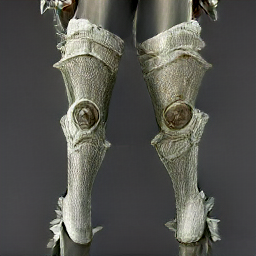

In [ ]:
showp(-2)

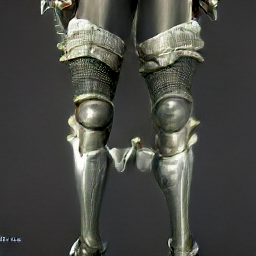

In [ ]:
showp(-3)

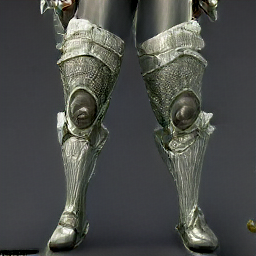

In [ ]:
showp(-4)

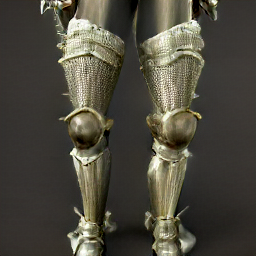

In [ ]:
showp(-5)

In [ ]:
aso=-1
dumped_seqs=np.fromfile('ozv.bin',dtype=np.uint16).astype(np.int32).reshape((-1,256))

In [ ]:
Treading=True #@param {type:"boolean"}
def intpenc():
  global aso
  asoni=aso-1
  interpo(dumped_seqs[aso],dumped_seqs[asoni])
  !rm /content/intp.webm
  !/content/ffmpeg-5.0.1-amd64-static/ffmpeg -framerate 18 -i /content/donn/%02d.png -sn -map_metadata -1 -map_chapters -1 -crf 10 -c:v libaom-av1 -aom-params enable-keyframe-filtering=0:enable-tpl-model=1 -lag-in-frames 48 -cpu-used 5 -row-mt 1 -tiles 1x1 -threads 2 -strict experimental -movflags +faststart -flags +cgop -pix_fmt yuv420p10le -c:a libopus -b:a 96k -ac 2 -f webm /content/intp.webm
  aso=asoni

if Treading:
  t1 = Thread(target = intpenc)
  a1 = t1.start()
else:
  intpenc()

# ffmpeg

In [ ]:
hydda=False #@param {type:"boolean"}
import os
if not os.path.exists('/content/avif'):
  !wget https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz
  !tar xvf /content/ffmpeg-release-amd64-static.tar.xz
  !mkdir /content/tt1
  !mkdir /content/tt2
  !mkdir /content/tt2/d




import shutil
import subprocess
from google.colab import output
from google.colab import files
from threading import Thread


def dl(url):
  global bzna
  rbzna=url.split('=')[1][:-4]
  if bzna=='':
    bzna=rbzna
  !wget --content-disposition {url}
  if url.endswith('.zip'):
    !7z x /content/{rbzna}.zip
  if rbzna != bzna:
    os.link(rbzna+'.mp4',bzna+'.mp4')



def runpyproc(na):
  subprocess.Popen(['python','/content/'+na+'.py'],close_fds=True)


def renya():
  sig='/content/avif/'+bzna.replace('-','_')+'-'
  avifz=os.listdir('/content/tt2')
  for aav in avifz:
    os.rename('/content/tt2/'+aav,sig+aav)

def loopdl():
  shutil.rmtree('/content/avif/.ipynb_checkpoints',ignore_errors=True)
  avifz=os.listdir('/content/avif')
  avifz.sort()
  if len(avifz) > 2:
    avifz=avifz[:2]
  for aviif in avifz:
    dzt='/content/avifbye/'+aviif
    srrc='/content/avif/'+aviif
    

    os.rename(srrc,dzt)
    files.download(dzt)

def enc(syg):
  !rm *.log
  !/content/ffmpeg-5.0.1-amd64-static/ffmpeg -i /content/tt1/{syg}.mp4 -pass 1 -passlogfile loga.log -sn -map_metadata -1 -map_chapters -1 -crf 40 -c:v libaom-av1 -aom-params enable-keyframe-filtering=0:enable-tpl-model=1 -lag-in-frames 48 -cpu-used 5 -row-mt 1 -tiles 1x1 -threads 2 -strict experimental -pix_fmt yuv420p10le -f null NUL
  !/content/ffmpeg-5.0.1-amd64-static/ffmpeg -i /content/tt1/{syg}.mp4 -pass 2 -passlogfile loga.log -sn -map_metadata -1 -map_chapters -1 -crf 40 -c:v libaom-av1 -aom-params enable-keyframe-filtering=0:enable-tpl-model=1 -lag-in-frames 48 -cpu-used 5 -row-mt 1 -tiles 1x1 -threads 2 -strict experimental -movflags +faststart -flags +cgop -pix_fmt yuv420p10le -c:a libopus -b:a 96k -ac 2 -f webm /content/tt2/{syg}.webm
  


In [ ]:
!/content/ffmpeg-5.0.1-amd64-static/ffmpeg -i /content/{bzna}.mp4 -an -c:v copy -f segment -segment_time 8.7 -reset_timestamps 1 /content/tt1/%03d.mp4
#   -c:a copy

In [ ]:
'''
!wget https://johnvansickle.com/ffmpeg/builds/ffmpeg-git-amd64-static.tar.xz
!tar xvf /content/ffmpeg-git-amd64-static.tar.xz
!/content/ffmpeg-git-20220622-amd64-static/ffmpeg -i interpo_mini.webm -c copy kat.avif
'''

In [ ]:
Treading=True #@param {type:"boolean"}
bznasf='/content/tt2/'+bzna.replace('-','_')+'-'
def wk1():
  for pp in range(100):
    syga='%03d'%pp
    if os.path.isfile('/content/tt1/'+syga+'.mp4'):
      enc(syga)
      os.rename('/content/tt2/'+syga+'.webm',bznasf+syga+'.webm')

if Treading:
  t1 = Thread(target = wk1)
  a1 = t1.start()
else:
  wk1()

rm: cannot remove '*.log': No such file or directory


ddal

In [ ]:
#
!rm -rf /content/tt1
#!rm -rf /content/tt2
!mkdir /content/tt1
!mkdir /content/tt2
!mkdir /content/tt2/d

mkdir: cannot create directory ‘/content/tt2’: File exists
mkdir: cannot create directory ‘/content/tt2/d’: File exists
